Data dimensions: (500, 500)
Covariance matrix shape: (500, 500)

Checking matrix properties:
Minimum eigenvalue: -1.42e-21
Maximum eigenvalue: 6.73e-06
Condition number: -4.73e+15

A. Performing Cholesky simulation...

B. Performing PCA simulation...

C. Comparing Frobenius norms...
Cholesky relative difference: 1.021510
PCA relative difference: 0.273168

D. Analyzing eigenvalue decay...

E. Timing comparison:
Cholesky simulation time: 0.6720 seconds
PCA simulation time: 0.3767 seconds

F. Additional metrics for tradeoff analysis:
PCA components used: 29 out of 500
Memory usage - Cholesky: 40.00 MB
Memory usage - PCA: 40.00 MB
Dimension reduction ratio: 5.80%


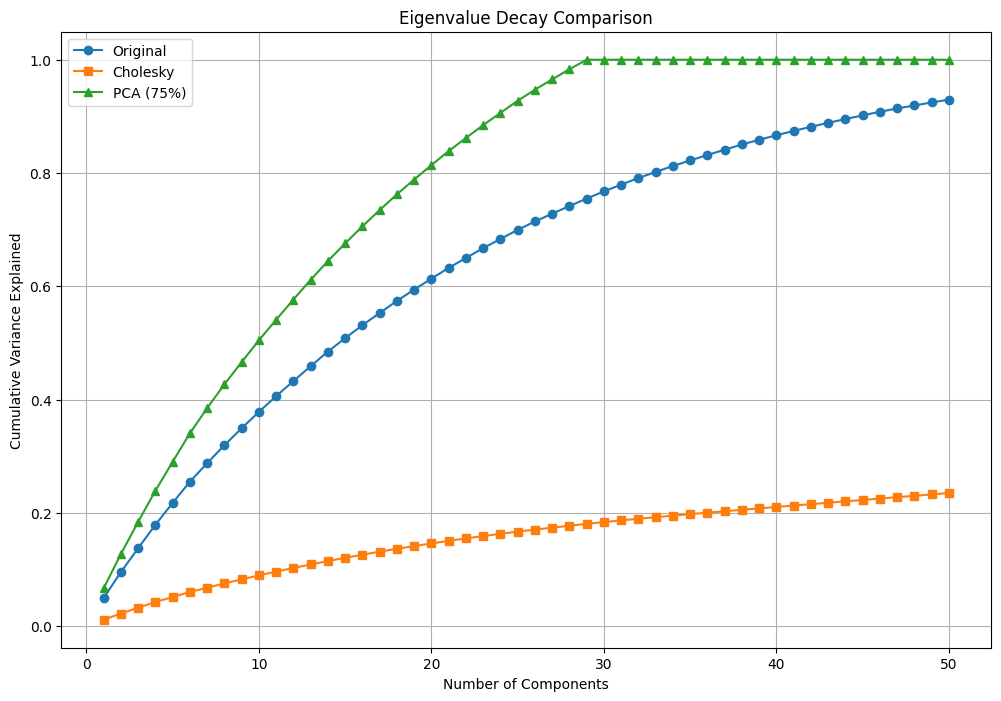

In [2]:
import numpy as np
import pandas as pd
from scipy import linalg
import time
import matplotlib.pyplot as plt

def near_psd(A, epsilon=0.0):
    """
    Calculate the nearest positive semi-definite matrix for a correlation/covariance matrix
    
    Parameters:
    -----------
    A : array_like
        Input array to be converted into the nearest positive semi-definite matrix
    epsilon : float
        Small adjustment for numerical stability
    
    Returns:
    --------
    A_psd : array_like
        Nearest positive semi-definite matrix
    """
    n = A.shape[0]
    eigval, eigvec = linalg.eigh(A)
    
    # Replace negative eigenvalues with small positive value
    eigval[eigval < epsilon] = epsilon
    
    # Reconstruct the matrix
    A_psd = eigvec @ np.diag(eigval) @ eigvec.T
    
    # Ensure symmetry
    A_psd = (A_psd + A_psd.T) / 2
    
    return A_psd

def simulate_mvn_cholesky(mean, cov, n_samples):
    """
    Simulate multivariate normal using Cholesky decomposition
    """
    start_time = time.time()
    
    # Ensure matrix is positive definite
    cov_psd = near_psd(cov, epsilon=1e-6)
    
    try:
        # Compute Cholesky decomposition
        L = linalg.cholesky(cov_psd, lower=True)
        
        # Generate standard normal samples
        Z = np.random.standard_normal((n_samples, len(mean)))
        
        # Transform to desired distribution
        X = Z @ L.T + mean
        
    except linalg.LinAlgError as e:
        print(f"Error in Cholesky decomposition: {e}")
        raise
    
    end_time = time.time()
    return X, end_time - start_time

def simulate_mvn_pca(mean, cov, n_samples, explained_var_ratio=0.75):
    """
    Simulate multivariate normal using PCA
    """
    start_time = time.time()
    
    # Compute eigendecomposition
    eigvals, eigvecs = linalg.eigh(cov)
    
    # Sort in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Handle negative eigenvalues
    eigvals = np.maximum(eigvals, 0)
    
    # Determine number of components needed
    total_var = np.sum(eigvals)
    cum_var_ratio = np.cumsum(eigvals) / total_var
    n_components = np.searchsorted(cum_var_ratio, explained_var_ratio) + 1
    
    # Keep only needed components
    eigvals_reduced = eigvals[:n_components]
    eigvecs_reduced = eigvecs[:, :n_components]
    
    # Generate standard normal samples
    Z = np.random.standard_normal((n_samples, n_components))
    
    # Transform to desired distribution
    X = Z @ np.diag(np.sqrt(eigvals_reduced)) @ eigvecs_reduced.T + mean
    
    end_time = time.time()
    return X, end_time - start_time

def analyze_simulations(file_path='problem6.csv', n_samples=10000):
    """
    Main analysis function
    """
    try:
        # Read and prepare data
        df = pd.read_csv(file_path)
        data = df.values
        
        # Calculate original covariance and mean
        orig_cov = np.cov(data.T)
        orig_mean = np.mean(data, axis=0)
        
        print("Data dimensions:", data.shape)
        print("Covariance matrix shape:", orig_cov.shape)
        
        print("\nChecking matrix properties:")
        eigvals = linalg.eigvalsh(orig_cov)
        print(f"Minimum eigenvalue: {np.min(eigvals):.2e}")
        print(f"Maximum eigenvalue: {np.max(eigvals):.2e}")
        print(f"Condition number: {np.max(eigvals)/np.min(eigvals):.2e}")
        
        # A. Cholesky simulation
        print("\nA. Performing Cholesky simulation...")
        chol_samples, chol_time = simulate_mvn_cholesky(orig_mean, orig_cov, n_samples)
        chol_cov = np.cov(chol_samples.T)
        
        # B. PCA simulation with 75% variance
        print("\nB. Performing PCA simulation...")
        pca_samples, pca_time = simulate_mvn_pca(orig_mean, orig_cov, n_samples, 0.75)
        pca_cov = np.cov(pca_samples.T)
        
        # C. Compare Frobenius norms
        print("\nC. Comparing Frobenius norms...")
        chol_diff_norm = linalg.norm(orig_cov - chol_cov, 'fro')
        pca_diff_norm = linalg.norm(orig_cov - pca_cov, 'fro')
        orig_norm = linalg.norm(orig_cov, 'fro')
        
        print(f"Cholesky relative difference: {chol_diff_norm/orig_norm:.6f}")
        print(f"PCA relative difference: {pca_diff_norm/orig_norm:.6f}")
        
        # D. Compare eigenvalue decay
        print("\nD. Analyzing eigenvalue decay...")
        
        def get_cum_var_ratio(cov):
            eigvals = linalg.eigvalsh(cov)[::-1]
            return np.cumsum(eigvals) / np.sum(eigvals)
        
        orig_cum_var = get_cum_var_ratio(orig_cov)
        chol_cum_var = get_cum_var_ratio(chol_cov)
        pca_cum_var = get_cum_var_ratio(pca_cov)
        
        # Plot cumulative variance
        plt.figure(figsize=(12, 8))
        n_plot = min(50, len(orig_cum_var))  # Plot first 50 components or less
        plt.plot(range(1, n_plot+1), orig_cum_var[:n_plot], 
                 label='Original', marker='o')
        plt.plot(range(1, n_plot+1), chol_cum_var[:n_plot], 
                 label='Cholesky', marker='s')
        plt.plot(range(1, n_plot+1), pca_cum_var[:n_plot], 
                 label='PCA (75%)', marker='^')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance Explained')
        plt.title('Eigenvalue Decay Comparison')
        plt.legend()
        plt.grid(True)
        
        # E. Compare timing
        print("\nE. Timing comparison:")
        print(f"Cholesky simulation time: {chol_time:.4f} seconds")
        print(f"PCA simulation time: {pca_time:.4f} seconds")
        
        # F. Additional analysis for tradeoffs
        print("\nF. Additional metrics for tradeoff analysis:")
        n_pca_components = np.searchsorted(orig_cum_var, 0.75) + 1
        print(f"PCA components used: {n_pca_components} out of {len(orig_cum_var)}")
        print(f"Memory usage - Cholesky: {chol_samples.nbytes / 1e6:.2f} MB")
        print(f"Memory usage - PCA: {pca_samples.nbytes / 1e6:.2f} MB")
        print(f"Dimension reduction ratio: {n_pca_components/len(orig_cum_var):.2%}")
        
        return {
            'cholesky': {
                'samples': chol_samples,
                'cov': chol_cov,
                'time': chol_time,
                'diff_norm': chol_diff_norm
            },
            'pca': {
                'samples': pca_samples,
                'cov': pca_cov,
                'time': pca_time,
                'diff_norm': pca_diff_norm
            },
            'original': {
                'cov': orig_cov,
                'cum_var': orig_cum_var
            },
            'figure': plt.gcf()
        }
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    results = analyze_simulations()